### Imports

In [2]:
import bertFuncs as func
from functions import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics.pairwise import cosine_similarity
from transformers import logging
logging.set_verbosity_error()
from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict
from nltk.corpus import wordnet as wn

from scipy.stats import ttest_ind
import math

import pathlib
import platform 

from functools import partial
from itertools import repeat
from multiprocessing import Pool, freeze_support
import multiprocess as mp
from functools import partial

import random

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

2023-01-09 00:10:17.453783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 00:10:20.778328: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-09 00:10:24.939946: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/bwhpc/common/devel/cuda/11.8/lib64
2023-01-09 00:10:24.940028: W tensorflow/compil

In [ ]:
# Import company list. 
company_names = pd.read_csv("sp500companynames.csv")
company_names.rename(columns = {"cleanedname":"Name"}, inplace = True)

# Manually Define Context List. 
#context_list = ["is employed", "was employed", "will be employed", "has been employed","leads a team", "was leading a team", "will be leading a team", "has been leading a team", "is leading a team"]
context_list = ["works", "worked", "will work", "has worked", "is working","is employed", "was employed", "will be employed", "has been employed"]
nouns = pd.read_csv('nouns.csv', sep=";")
nouns = nouns[nouns['nouns'].str.strip().str.split(' ').str.len().eq(1)] # Only considering single word nouns.
nouns_sample = nouns["nouns"].sample(n = 800, random_state = 42)
nouns_sample = list(nouns_sample)

# Avoid overlap between nouns and companies. 
company_names["Name_Lower"] = company_names['Name'].str.lower()
nouns_sample = [x for x in nouns_sample if x not in list(company_names["Name_Lower"])]

# Import and prepare dictionaries. 
dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries["tuple"] = list(zip(dictionaries["Term1"].astype(str), dictionaries["Term2"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)

unique_dictionaries = dictionaries.drop_duplicates(subset='tuple', keep="last")
unique_dictionaries.reset_index(inplace = True)

In [ ]:
# Set variables
method = "Method_3"
companies = company_names["Name"]
num_of_dim = 111
all_dimensions = dictionaries["tuple"].unique()

### Generate Embeddings

In [12]:
def get_embedding_method_1(context, embedded_word, numPolar, method): 
    
    # Create dataframe for final embedding. 
    embedding = pd.DataFrame()
    
    # Create path for storing the embedding files. 
    pathlib.Path(f'./{method}/').mkdir(parents=True, exist_ok=True) 
    
    # Split multi-word names to get average embedding. 
    all_words = embedded_word.split(" ")
    
    # Define full context. 
    male_context = f"He {context} at {embedded_word}"
    female_context = f"She {context} at {embedded_word}"
    
    for word in all_words: 

        # Get embeddings for male and female context.
        male_embedding = pd.DataFrame(func.analyzeWord(word, male_context ,numberPolar = numPolar)).transpose()
        male_embedding = male_embedding.rename(columns={2: 'Value_Male'})
        male_embedding.drop([0, 1], axis = 1, inplace = True)

        female_embedding = pd.DataFrame(func.analyzeWord(word, female_context ,numberPolar = numPolar)).transpose()
        female_embedding = female_embedding.rename(columns={2: 'Value_Female'})

        # Merge embeddings. 
        df_merged = pd.merge(male_embedding, female_embedding, left_index=True, right_index=True)
        df_merged["male-female"] = df_merged["Value_Male"] - df_merged["Value_Female"]
        df_merged["tuple"] = list(zip(df_merged[0], df_merged[1]))
    
        embedding[[f"{word}_male", f"{word}_female", "tuple"]] = df_merged[["Value_Male", "Value_Female", "tuple"]]
        
    # Take average of different name parts. 
    embedding["average_male"] = embedding.loc[:, embedding.columns.str.endswith('_male')].mean(axis=1).round(7)
    embedding["average_female"] = embedding.loc[:, embedding.columns.str.endswith('_female')].mean(axis=1).round(7)

    # Calculate delta / bias. 
    embedding["male-female"] = (embedding["average_male"] - embedding["average_female"]).round(7)

    # Store for faster import later. 
    embedding.sort_index(inplace=True)
    embedding.to_csv(f"./{method}/{embedded_word}_{context}.csv")

#### Create Embeddings for Companies and Nouns

In [13]:
# Create company embeddings
for company in tqdm(companies): 
    mp.Pool().starmap(get_embedding_method_1, zip(context_list, repeat(company), repeat(111), repeat("Method_1")))

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
# Create random noun embeddings
for noun in tqdm(nouns_sample): 
    mp.Pool().starmap(get_embedding_method_1, zip(context_list, repeat(noun), repeat(111), repeat("Method_1")))

In [14]:
# Calculate average company embedding over context list. 
for company in tqdm(company_names["Name"]):
    result = pd.DataFrame()
    final_result = pd.DataFrame()
    
    for context in context_list:
        file = pd.read_csv(f"./{method}/{company}_{context}.csv")
        file = file.iloc[: , 1:]
        result = pd.concat([result, file], axis=1, join="outer")
        
    final_result["tuple"] = file["tuple"]
    final_result["context_average_male"] = result.loc[:, result.columns.str.startswith('average_male')].mean(axis=1).round(7)
    final_result["context_average_female"] = result.loc[:, result.columns.str.startswith('average_female')].mean(axis=1).round(7)
    final_result["average_male-female"] = final_result["context_average_male"] - final_result["context_average_female"]
    final_result.to_csv(f"./{method}/{company}_context_average.csv")

  0%|          | 0/782 [00:00<?, ?it/s]

## Analyze Embeddings

In [15]:
# Define helper functions. 

def read_embedding_values(company_names, antonym_pair, method): 
    
    result = pd.DataFrame()
    result["company"] = company_names
    result["value_male"] = 0
    result["value_female"] = 0
    result["value_neutral"] = 0 
    result["difference"] = 0

    for company in company_names: 
        comparison = pd.read_csv(f"./{method}/{company}_context_average.csv")

        comparison = comparison.groupby("tuple", as_index = False).mean() # Account for duplicates.         
        value_male = float(comparison[comparison["tuple"] == antonym_pair]["context_average_male"])
        value_female = float(comparison[comparison["tuple"] == antonym_pair]["context_average_female"])
        #value_neutral = float(comparison[comparison["tuple"] == antonym_pair]["context_average_neutral"])
        
        difference = value_male - value_female
        result["value_male"].loc[result["company"] == company] = value_male
        result["value_female"].loc[result["company"] == company] = value_female
        #result["value_neutral"].loc[result["company"] == company] = value_neutral
        result["difference"].loc[result["company"] == company] = difference
    
    return result   

def check_significance(p_value): 
    if p_value < 0.05: 
        stat_res = "Significant Difference"
    else: 
        stat_res = "No Significant Difference"
        
    return stat_res

def round_decimals_up(number:float, decimals:int=2):
    """
    Returns a value rounded up to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more")
    elif decimals == 0:
        return math.ceil(number)

    factor = 10 ** decimals
    return math.ceil(number * factor) / factor

In [16]:
male_color_code = "black"
female_color_code = '#3AA8F3'

In [33]:
def get_dimension_distribution(considered_companies, antonym_pair, nouns_sample, method): 
    
    result = read_embedding_values(considered_companies, antonym_pair, method)
    rand_result = read_embedding_values(nouns_sample, antonym_pair, method)
    

    fig = plt.figure(constrained_layout=True, figsize=(13, 4))
    
    gs = GridSpec(2, 1, figure=fig)
    fig.suptitle(f"Distributions for {str(antonym_pair)}", weight="bold")

    # Plot male and female distribution 
    stat, p_value = ttest_ind(result["value_male"], result["value_female"])
    ax1 = fig.add_subplot(gs[0, :])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.set_title(f"Male vs. Female Firm Distribution ({check_significance(p_value)}, p-value = {round_decimals_up(p_value, 3)})", fontsize=9)
    sns.distplot(result["value_male"], ax = ax1, label = "Male Context", color = male_color_code)
    sns.distplot(result["value_female"], ax = ax1, label = "Female Context", color = female_color_code)
    #plt.axvline(0, color = "black", ls = "--")
    plt.axvline(result["value_male"].mean(), color = male_color_code)
    plt.axvline(result["value_female"].mean(), color = female_color_code)
    plt.legend() 
    
    # Plot difference
    stat, p_value = ttest_ind(result["difference"], rand_result["difference"])
    ax4 = fig.add_subplot(gs[1, :])
    ax4.set_title(f"Corporate vs. Random Difference ({check_significance(p_value)}, p-value = {round_decimals_up(p_value, 3)})", fontsize=9)
    sns.distplot(result["difference"], ax = ax4, label = "Firm difference", color = "cyan")
    sns.distplot(rand_result["difference"], ax = ax4, label = "random difference", color = "grey")
    #plt.axvline(0, color = "black", ls = "--")
    plt.axvline(rand_result["difference"].mean(), color = "grey")
    plt.axvline(result["difference"].mean(), color = "cyan")
    
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    plt.legend()
    
    pathlib.Path(f'./{method}/distribution_plots').mkdir(parents=True, exist_ok=True) 
    plt.savefig(f'./{method}/distribution_plots/{antonym_pair}.png', bbox_inches = "tight",transparent=True)

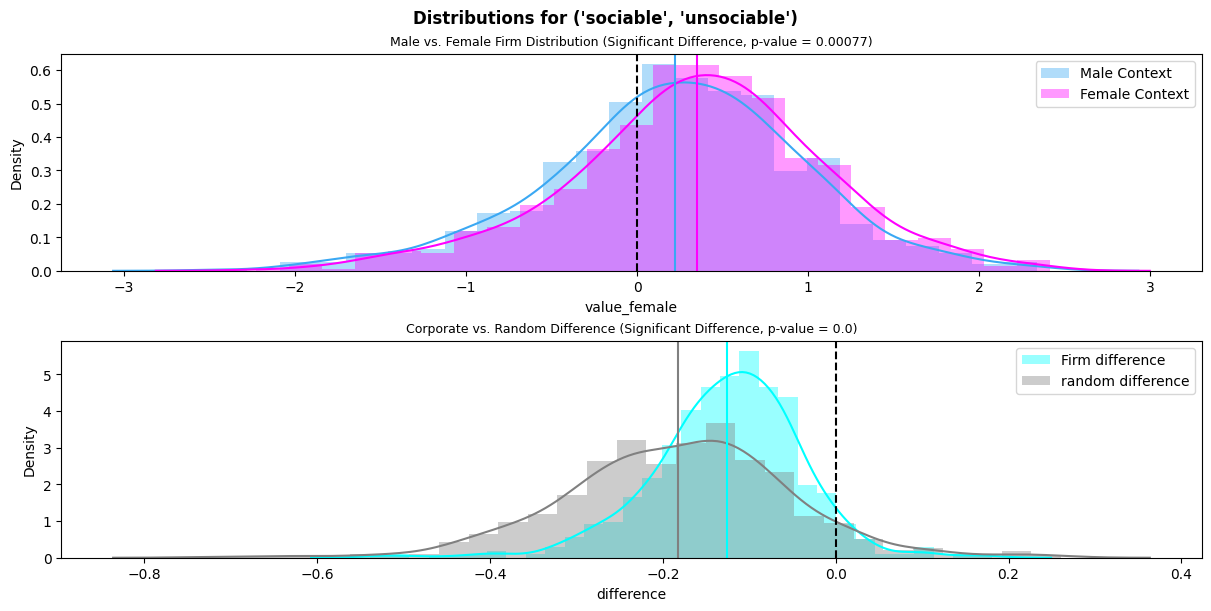

In [35]:
get_dimension_distribution(company_names["Name"], "('sociable', 'unsociable')", nouns_sample, "Method_1")

In [17]:
res_table = pd.DataFrame()
res_table["Dimension"] = all_dimensions
res_table["P-Value M vs. F Firm Embedding"] = 0 
res_table["P-Value Delta Firm vs. Delta Random Embedding"] = 0
res_table["Mean Firm"] = 0
res_table["Mean Random"] = 0

# Loop through all unique dimensions. 
for dimension in tqdm(all_dimensions): 

    # Get and append p-values for dimension. 
    result = read_embedding_values(companies, dimension, method)
    rand_result = read_embedding_values(nouns_sample, dimension, method)
    
    stat1, p_value1 = ttest_ind(result["value_male"], result["value_female"])
    stat2, p_value2 = ttest_ind(result["difference"], rand_result["difference"])
    
    res1 = round(p_value1, 5)
    res2 = round(p_value2, 5)
    
    res_table["P-Value M vs. F Firm Embedding"].loc[res_table["Dimension"] == dimension] = round_decimals_up(res1, 5)
    res_table["P-Value Delta Firm vs. Delta Random Embedding"].loc[res_table["Dimension"] == dimension] = round_decimals_up(res2, 5)

    # Get mean bias values. 
    res_table["Mean Firm"].loc[res_table["Dimension"] == dimension] = result["difference"].mean()
    res_table["Mean Random"].loc[res_table["Dimension"] == dimension] = rand_result["difference"].mean()
    res_table["Mean Firm vs. Mean Random"] = res_table["Mean Firm"] - res_table["Mean Random"]
    
res_table["Dictionary"] = unique_dictionaries["Dictionary"]

  0%|          | 0/101 [00:00<?, ?it/s]

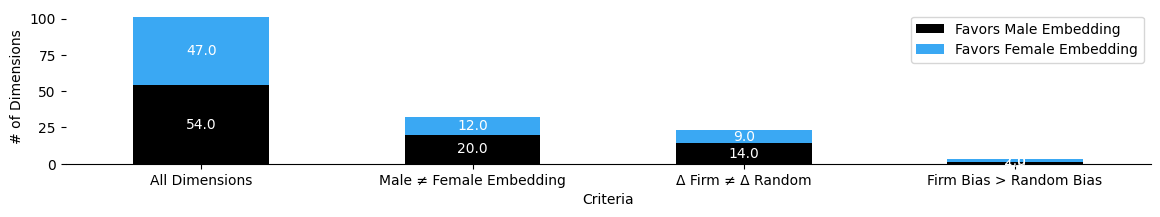

In [18]:
# Plot dimension significance. 
sign_level = 0.05

# Get dataframe. 
dimension_analysis_df = pd.DataFrame({"Favors Male Embedding":[
    len(res_table[res_table.iloc[:, 3] < 0]), 
    len(res_table[(res_table.iloc[:, 3] < 0) & (res_table.iloc[:, 1] < sign_level)]),
    len(res_table[(res_table.iloc[:, 3] < 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level)]),
    len(res_table[(res_table.iloc[:, 3] < 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level) & (res_table.iloc[:, 3] < res_table.iloc[:, 4])])    
    ],
                                        "Favors Female Embedding":[
    len(res_table[res_table.iloc[:, 3] > 0]), 
    len(res_table[(res_table.iloc[:, 3] > 0) & (res_table.iloc[:, 1] < sign_level)]), 
    len(res_table[(res_table.iloc[:, 3] > 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level)]), 
    len(res_table[(res_table.iloc[:, 3] > 0) & (res_table.iloc[:, 1] < sign_level) & (res_table.iloc[:, 2] < sign_level) & (res_table.iloc[:, 3] > res_table.iloc[:, 4])])      
    ]    
},
    index = ["All Dimensions", "Male ≠ Female Embedding", "Δ Firm ≠ Δ Random", "Firm Bias > Random Bias"]
)

# Plot results. 
ax = dimension_analysis_df.plot(kind='bar', stacked=True, color=[male_color_code, female_color_code], figsize=(14, 2), )
plt.xticks(rotation=0)
plt.xlabel('Criteria')
plt.ylabel('# of Dimensions')
#plt.title('Dimension Bias', weight = "bold")

for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color = "white")
pathlib.Path(f'./{method}/distribution_plots').mkdir(parents=True, exist_ok=True) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig(f'./{method}/distribution_plots/dimension_bias.png', bbox_inches = "tight", transparent=True)

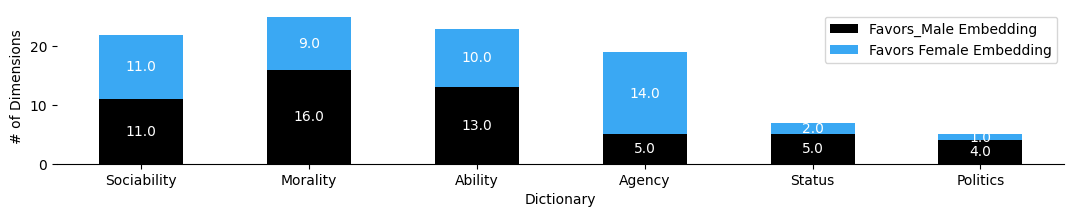

In [19]:
dictionary_results = {}

favors_male = []
favors_female = []

for dictionary in dictionaries["Dictionary"].unique(): 
    favors_male.append(len(res_table[(res_table["Dictionary"] == dictionary) & (res_table["Mean Firm"] < 0)]))
    favors_female.append(len(res_table[(res_table["Dictionary"] == dictionary) & (res_table["Mean Firm"] > 0)]))
    
    dictionary_results["Favors_Male Embedding"] = favors_male
    dictionary_results["Favors Female Embedding"] = favors_female
    
dictionary_results_df = pd.DataFrame(dictionary_results, index = dictionaries["Dictionary"].unique())

# Plot results. 
ax = dictionary_results_df.plot(kind='bar', stacked=True, color=[male_color_code, female_color_code], figsize=(13, 2), )
plt.xticks(rotation=0)
plt.xlabel('Dictionary')
plt.ylabel('# of Dimensions')
#plt.title('Dictionary Results', weight = "bold")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color = "white")
pathlib.Path(f'./{method}/distribution_plots').mkdir(parents=True, exist_ok=True) 
plt.savefig(f'./{method}/distribution_plots/dict_res.png', bbox_inches = "tight", transparent=True)

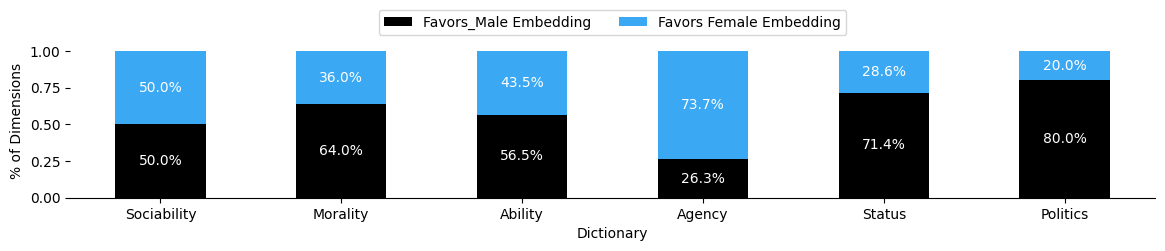

In [25]:
dictionary_results = {}

favors_male = []
favors_female = []

for dictionary in dictionaries["Dictionary"].unique(): 
    
    num_dim = len(res_table[res_table["Dictionary"] == dictionary])
    favoring_male = len(res_table[(res_table["Dictionary"] == dictionary) & (res_table["Mean Firm"] < 0)])
    favoring_female = len(res_table[(res_table["Dictionary"] == dictionary) & (res_table["Mean Firm"] > 0)])
    perc_male = favoring_male / num_dim
    perc_female = favoring_female / num_dim
    
    
    favors_male.append(perc_male)
    favors_female.append(perc_female)
    
    dictionary_results["Favors_Male Embedding"] = favors_male
    dictionary_results["Favors Female Embedding"] = favors_female
    
dictionary_results_df = pd.DataFrame(dictionary_results, index = dictionaries["Dictionary"].unique())

# Plot results. 
ax = dictionary_results_df.plot(kind='bar', stacked=True, color=[male_color_code, female_color_code], figsize=(14, 2), )
plt.xticks(rotation=0)
plt.xlabel('Dictionary')
plt.ylabel('% of Dimensions')
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc='upper center',
                 borderaxespad=0, ncol=3)

#plt.title('Dictionary Results', weight = "bold")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
for c in ax.containers:
    labels = [f"{round(v.get_height()*100,1)}%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', color = "white")
pathlib.Path(f'./{method}/distribution_plots').mkdir(parents=True, exist_ok=True) 
plt.savefig(f'./{method}/distribution_plots/dict_res.png', bbox_inches = "tight", transparent=True)

### Robustness 

In [22]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [23]:
cronbach_alpha_results = {}

for dictionary in tqdm(dictionaries["Dictionary"].unique()): 

    all_firms = pd.DataFrame()

    for firm in company_names["Name"].unique(): 
        res = pd.read_csv(f"./{method}/{firm}_context_average.csv")
        res = res[["tuple", "average_male-female"]].groupby("tuple", sort = False).mean().reset_index()
        res["Dictionary"] = unique_dictionaries["Dictionary"]
        res = res[res["Dictionary"] == dictionary]
        res.drop("Dictionary", axis = 1, inplace = True)
        res.set_index ("tuple", inplace = True)
        res = res.transpose()
        res = res.reset_index(drop = True)
        res["Company"] = firm
        all_firms = all_firms.append(res)
    
    all_firms = all_firms.reset_index(drop = True)
    all_firms.iloc[:, :-1] = all_firms.iloc[:, :-1].rank()
    
    cronbach_alpha_results[dictionary] = [cronbach_alpha(all_firms.iloc[:, :-1])]    
    


  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
all_firms = pd.DataFrame()

for firm in tqdm(company_names["Name"].unique()): 
    res = pd.read_csv(f"./{method}/{firm}_context_average.csv")
    res = res[["tuple", "average_male-female"]].groupby("tuple", sort = False).mean().reset_index()
    res["Dictionary"] = unique_dictionaries["Dictionary"]
    res = res[res["Dictionary"] == "Status"]
    res.drop("Dictionary", axis = 1, inplace = True)
    res.set_index ("tuple", inplace = True)
    res = res.transpose()
    res = res.reset_index(drop = True)
    res["Company"] = firm
    all_firms = all_firms.append(res)

  0%|          | 0/778 [00:00<?, ?it/s]

In [117]:
sns.set_style(style='white')

Text(0.5, 1.0, "Cronbach's Alpha for Dictionaries")

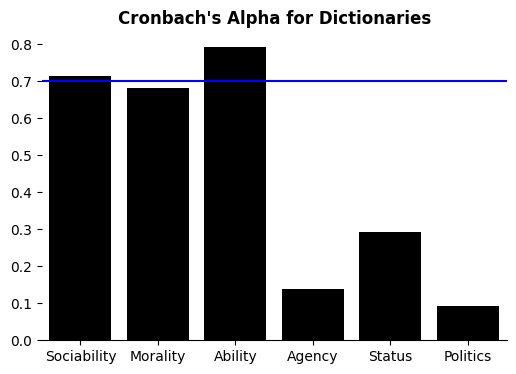

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(pd.DataFrame(cronbach_alpha_results), color = "black", ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axhline(0.70, color = "blue")
plt.savefig(f'./{method}/distribution_plots/cronbach_res.png', bbox_inches = "tight", transparent=True)
plt.title("Cronbach's Alpha for Dictionaries", weight = "bold")

In [105]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

In [28]:
# Robustness of tenses and synonyms 

context_robustness = pd.DataFrame()
context_robustness["tuple"] = dictionaries["tuple"].unique()

for context in tqdm(context_list):
    result = pd.DataFrame()
    for company in companies:
        file = pd.read_csv(f"./{method}/{company}_{context}.csv")
        file = file["male-female"]
        result = pd.concat([result, file], axis=1, join="outer")
        
    result = pd.DataFrame(result.loc[:, result.columns.str.startswith('male-female')].mean(axis=1).round(7), columns = ["male-female"])
    
    result["tuple"] = dictionaries["tuple"]
    result = result.groupby("tuple").mean().reset_index()
    context_robustness[context] = result["male-female"]


  0%|          | 0/9 [00:00<?, ?it/s]

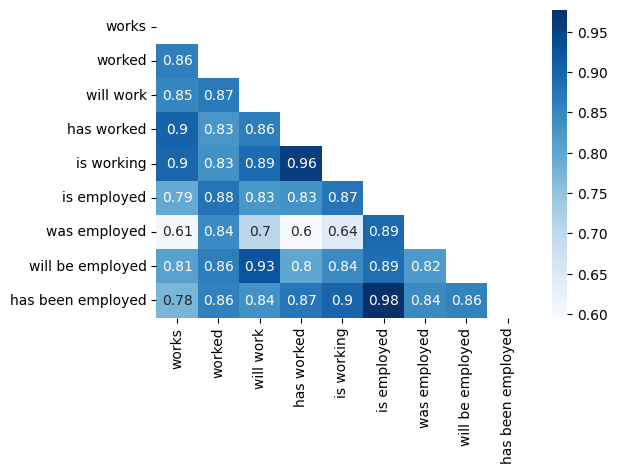

In [29]:


df_corr = context_robustness.drop("tuple", axis = 1).corr()
matrix = np.triu(df_corr)

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df_corr, annot = True, mask = matrix, cmap = "Blues", ax = ax)
fig.savefig(f'./{method}/distribution_plots/tenses_corr.png', bbox_inches = "tight", transparent=True)

  0%|          | 0/778 [00:00<?, ?it/s]

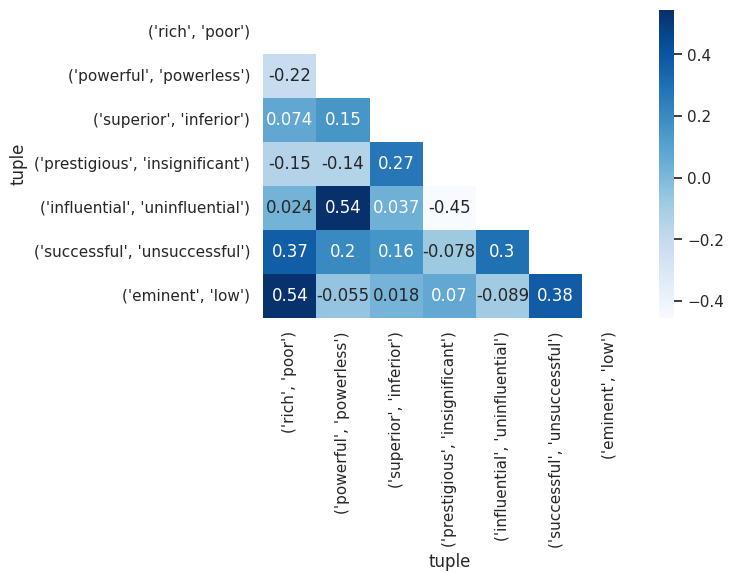

In [161]:
all_firms = pd.DataFrame()

for firm in tqdm(company_names["Name"].unique()): 
    res = pd.read_csv(f"./{method}/{firm}_context_average.csv")
    res = res[["tuple", "average_male-female"]].groupby("tuple", sort = False).mean().reset_index()
    res["Dictionary"] = unique_dictionaries["Dictionary"]
    res = res[res["Dictionary"] == "Status"]
    res.drop("Dictionary", axis = 1, inplace = True)
    res.set_index ("tuple", inplace = True)
    res = res.transpose()
    res = res.reset_index(drop = True)
    res["Company"] = firm
    all_firms = all_firms.append(res)
fig, ax = plt.subplots(figsize=(6, 4))

corr = all_firms.drop("Company", axis = 1).corr(method = 'spearman')
matrix = np.triu(corr)
sns.heatmap(corr, annot = True, mask = matrix, cmap="Blues", ax = ax)


fig.savefig(f'./{method}/distribution_plots/dict_res.png', bbox_inches = "tight", transparent=True)

In [15]:
# Read and prepare dictionaries. 

dictionaries = pd.read_csv("dimensions_matched_manual.csv", sep = ";", index_col = 0)
dictionaries["tuple"] = list(zip(dictionaries["Term1"].astype(str), dictionaries["Term2"].astype(str)))
dictionaries = dictionaries[["Dictionary", "tuple"]]
dictionaries["tuple"] = dictionaries["tuple"].astype(str)

unique_dictionaries = dictionaries["Dictionary"].unique()
unique_dictionaries.sort()

dictionaries = dictionaries.drop_duplicates(subset='tuple', keep="last")

res_table["Dictionary"] = dictionaries["Dictionary"]
dictionaries.reset_index(inplace = True)

In [37]:
dictionaries = dictionaries.drop_duplicates(subset='tuple', keep="last")

In [48]:
res_table["Dictionary"] = dictionaries["Dictionary"]
dictionaries.reset_index(inplace = True)

In [73]:
# % Of dictionary that is biased toward male context 

dictionary = "Status"


len (res_table[(res_table["Dictionary"] == f"{dictionary}") & (res_table["Mean Firm"] < 0)])/ len(res_table[res_table["Dictionary"] == f"{dictionary}"])

0.5714285714285714

In [63]:
unique_dictionaries

array(['Ability', 'Agency', 'Morality', 'Politics', 'Sociability',
       'Status'], dtype=object)